In [1]:
# importing Libraries
import numpy as np
from IPython.display import Image

Let's start with initiating weight matrix W and bias vector b for each layer.

In [2]:
NN_ARCHITECTURE = [
    {"input_dim":2, "output_dim":25, "activation":"relu"},
    {"input_dim":25, "output_dim":50, "activation":"relu"},
    {"input_dim":50, "output_dim":50, "activation":"relu"},
    {"input_dim":50, "output_dim":25, "activation":"relu"},
    {"input_dim":25, "output_dim":1, "activation":"sigmoid"}
]

Let's initialize the layer parameters.
Initial weight values cannot be equal because it leads to breaking symmetry problme.
because, if all the weights are same, no matter what was the input X, all units in hidden layer will be the same too, therefore we get stuck in the initial state without any hope for escape, no matter how long we train our model or how deep our network is.
Small initial values increases the effeciency of our algorithm during first iterations.
A sigmoid graph reaches the highest derivative value for numbers when close to zero and this has significant effect on speed of learning.


In [3]:
def init_layers(nn_architecture, seed=99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage
    params_values = {}
    
    # iterate over network layers
    for idx, layer in enumerate(nn_architecture):
        # start numbering layers from 1
        layer_idx = idx + 1

        layer_input_size = layer['input_dim']
        layer_output_size = layer['output_dim']
        
        params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
    return params_values
    

# Activation Function<br>
Activation function gives neural networks non-linearity.<br>
There are many activation functions, but we will use 2 of them - ReLu and Sigmoid.<br>
We also have to prepare their derivatives in order to be able to go full circle and pass both forward and backward propogation.


In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_backwards(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backwards(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

# Single layer forward propogation step
* Given input from previous layer, we compute affine transformation Z and then apply selected activation function.
* By using NumPy, we can leverage vectorization - performing matrix operations, for whole layer and whole batch of examples at once.
* This eliminates iteration and significantly increases the speed of the calculations.

In [5]:
def single_layer_forward_propogation(A_prev, W_curr, b_curr, activation='relu'):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == 'relu':
        activation_func = relu
    elif activation == 'sigmoid':
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
    
    return activation_func(Z_curr), Z_curr

# Full Forward propogation

In [31]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propogation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

# Calculating cost
* to monitor the progress we should regularly calculate the value of the loss function.
* It is selected according to the problem we plan to solve.
* because our NN is performing classificaition between 2 classes, we can use binary crossentropy.

In [32]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    #cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    
    return np.squeeze(cost)

# Calculating accuracy

In [33]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    
    return probs_

In [34]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    
    return (Y_hat_==Y).all(axis=0).mean()

# Single layer backward propogation step
* In NN, we calculate the gradient of the cost function (discussed earlier) in respect to parameters, but backpropogation can be used to calculate derivatives of any function.
* The essence of this algorithm is recursive use of chain rule known from differential calculus - calculate a derivative of function created by assembling other functions, whose derivatives we already know.

In [35]:
def single_layer_backward_propogation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
    m = A_prev.shape[1]
    
    if activation == 'relu':
        backward_activation_func = relu_backwards
    elif activation == 'sigmoid':
        backward_activation_func = sigmoid_backwards
    else:
        raise Exception('Non-supported activation function')
    
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    dW_curr = np.dot(dZ_curr, A_prev.T)/m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr

# Full backward propogation

In [36]:
def full_backward_propogation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    m = Y.shape[1]
    
    Y = Y.reshape(Y_hat.shape)
    
    dA_prev = -(np.divide(Y, Y_hat) - np.divide(1-Y, 1-Y_hat))
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_funciton_curr = layer['activation']
        
        dA_curr = dA_prev
        
        A_prev = memory['A' + str(layer_idx_prev)]
        Z_curr = memory['Z' + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propogation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_funciton_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)]  =db_curr
        
    return grads_values

# Updating parameters values

In [37]:
def update(params_values, grads_values, nn_architecure, learning_rate):
    for layer_idx, layer in enumerate(nn_architecure, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
    
    return params_values

# putting things together

In [38]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    params_values = init_layers(nn_architecture, 2)
    
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        grads_values = full_backward_propogation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if (i % 50 == 0):
            if verbose:
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if callback is not None:
                callback(i, params_values)
    return params_values

# US vs THEM

In [39]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

In [40]:
N_SAMPLES = 1000
TEST_SIZE = 0.1

In [41]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [42]:
X.shape

(1000, 2)

In [43]:
y.shape

(1000,)

In [70]:
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style('whitegrid')
        
    plt.figure(figsize=(16, 12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha=1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if file_name:
        plt.savefig(file_name)
        plt.close()

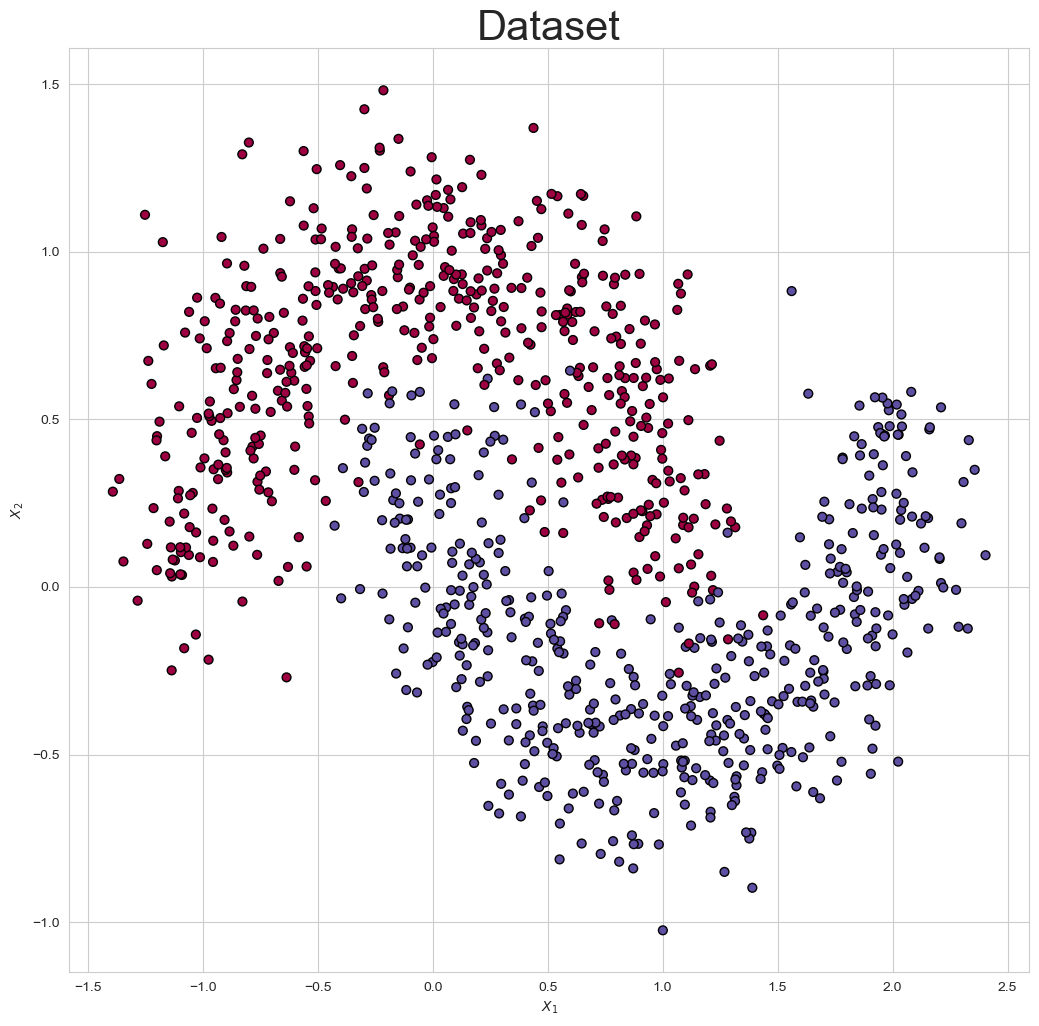

In [71]:
make_plot(X, y, "Dataset")

In [72]:
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)

In [73]:
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [74]:
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 0.98 - David


In [75]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./"

In [76]:
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [77]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [78]:
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, False, callback_numpy_plot)

C:\Users\Deepesh Kothari\AppData\Local\Temp\ipykernel_6552\407194231.py:16: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
C:\Users\Deepesh Kothari\AppData\Local\Temp\ipykernel_6552\407194231.py:16: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
C:\Users\Deepesh Kothari\AppData\Local\Temp\ipykernel_6552\407194231.py:16: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
C:\Users\Deepesh Kothari\AppData\Local\Temp\ipykernel_6552\407194231.py:16: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
C:\Users\Deepesh Kothari\AppData\Local\Temp\ipykernel_6552\407194231.py:

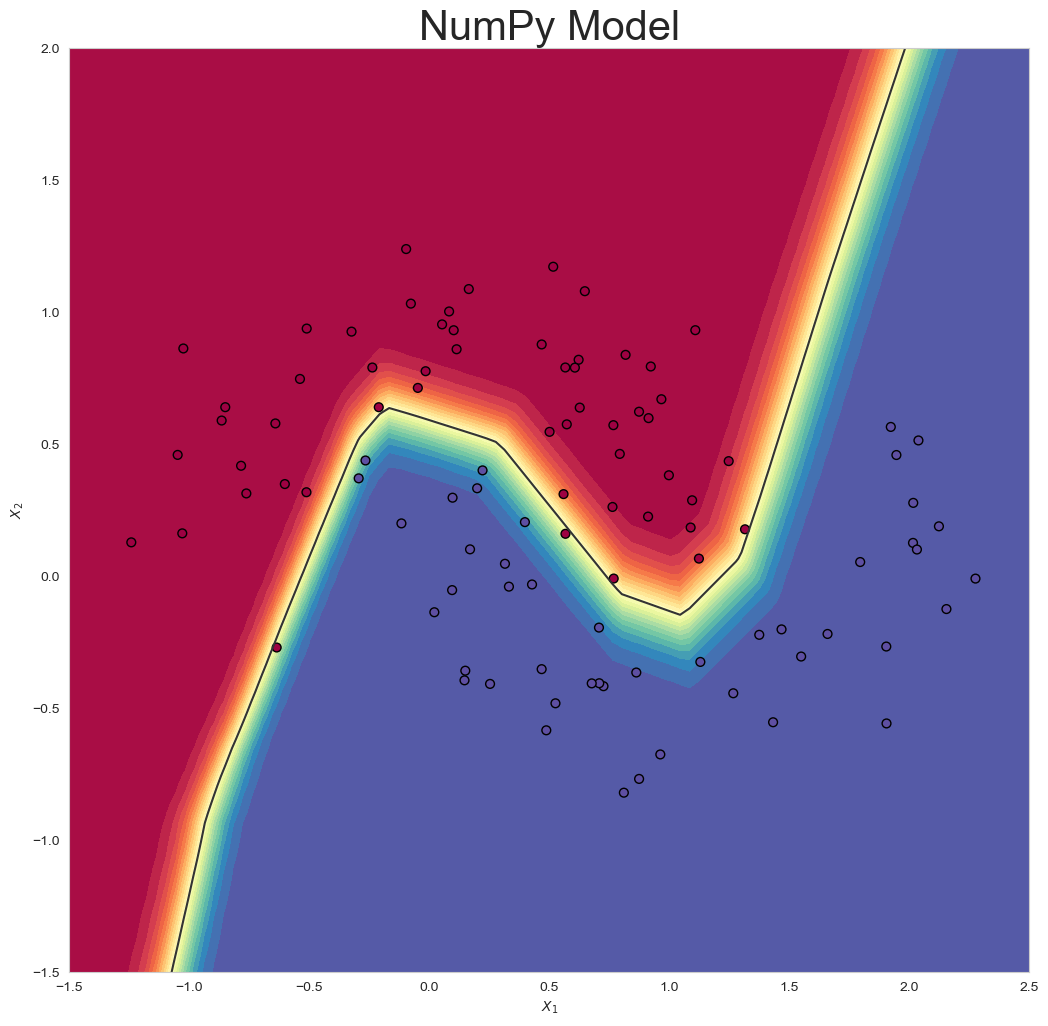

In [79]:
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)